**General instructions:** 
- This task is intended to be a general DS assessment. If you have applied for an Operational Research role, please contact your recruiter. 
- Please, explain any step or though that you think may be important to evaluate your task. 
- The expected programming language is **python**

- For the sake of the review, we **strongly prefer** to receive back a jupyter notebook containing all the code, comments and thoughts. This notebook should work from end to end, so we can `restart and run all` or  go through it, cell by cell, if we needed to do so.

In [1]:
# Move to the correct directory
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
os.chdir(module_path)

In [2]:
# Import all necessary code
# for better visualisation of the results
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


from tesco.data.preprocessing import load_preprocessed_data
from tesco.exploration.inspection import distribution_view, top_correlated_features
from tesco import sales_model

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# for better visualization of the results
warnings.filterwarnings("ignore")

# TESCO STORES Dataset

At Tesco, the location of a retail store plays a huge role in its commercial success. Our Stores Team use various data sources to better understand the potential of candidate locations for new stores in the UK. They need data science help in designing a model that can predict the future sales **[normalised_sales]** of a store based on location characteristics. Your task is to examine the provided dataset and answer the questions below.

Dataset files
* `tesco-dataset/train.csv`
* `tesco-dataset/test.csv`

Columns
* `location_id`: id of Tesco property location
* `normalised_sales`: normalised sales value of Tesco store
* `crime_rate`: crime rate in the area (higher means more crime)
* `household_size`: mean household size in the area
* `household_affluency`: mean household affluency in the area (higher means more affluent)
* `public_transport_dist`: index of public transport availability in the area
* `proportion_newbuilds`: proportion of newly built property in the area
* `property_value`: average property value in the area
* `commercial_property`: percentage of commercial properties in the area
* `school_proximity`: average school proximity in the area
* `transport_availability`: availability of different transport
* `new_store`: new Tesco store opened recently
* `proportion_nonretail`: proportion of non-retail commercial properties in the area
* `competitor_density`: density of competitor retailers
* `proportion_flats`: proportion of blocks of flats in the area
* `county`: county code of the area

-------------

## Q1
Before diving into the modelling, you are given the dataset and the Stores Team expect you to come back with an analysis of the data and any concerns you may have about it. They would also like to know which other information you think would be useful to collect for future developments.

### The test set is very small

The test set contains 13 locations. The total data is composed of 333 locations. The dataset is not big to start with, but the size of the test set corresponds to ~4% of the data. Working with at least 10-15% of the data reserved for the test set is common practice. This is important to allow for statistically significant validation of the model, to have enough diversity of data to make the test reliable and to establish if the model is overfitting. However, [Question 3](#Q3) suggests that we are using the model to predict sales to this split of the data. Therefore, this is not a problem. 

### The test set is biased in relation to some relevant variables.

1. **Biased variables**: On a visual inspection ([Fig. 1](#Figure-1:)), the test set is notably biased in relation to `crime_rate`, `commercial_property` and `household_size`. The reason I have not performed any statistical analysis to evaluate this is that, as I have mentioned before, the test set is very small, so using statistical tests to detect bias here would not be very productive.
2. **`normalised_sales` missing:** There are no `normalised_sales` values for the test set.
If the idea is to use the model to predict the `normalised_sales` values in this dataset, as [Question 3](#Q3) suggests, that would not be a problem. However, the name “test” is normally used to refer to the dataset used to test the quality of the model, which would not be possible in this case. I assume that you have the correct expected values and you will compare them to my predicted values, so I perform other data splits to train and test a proposed model.

### Figure 1:

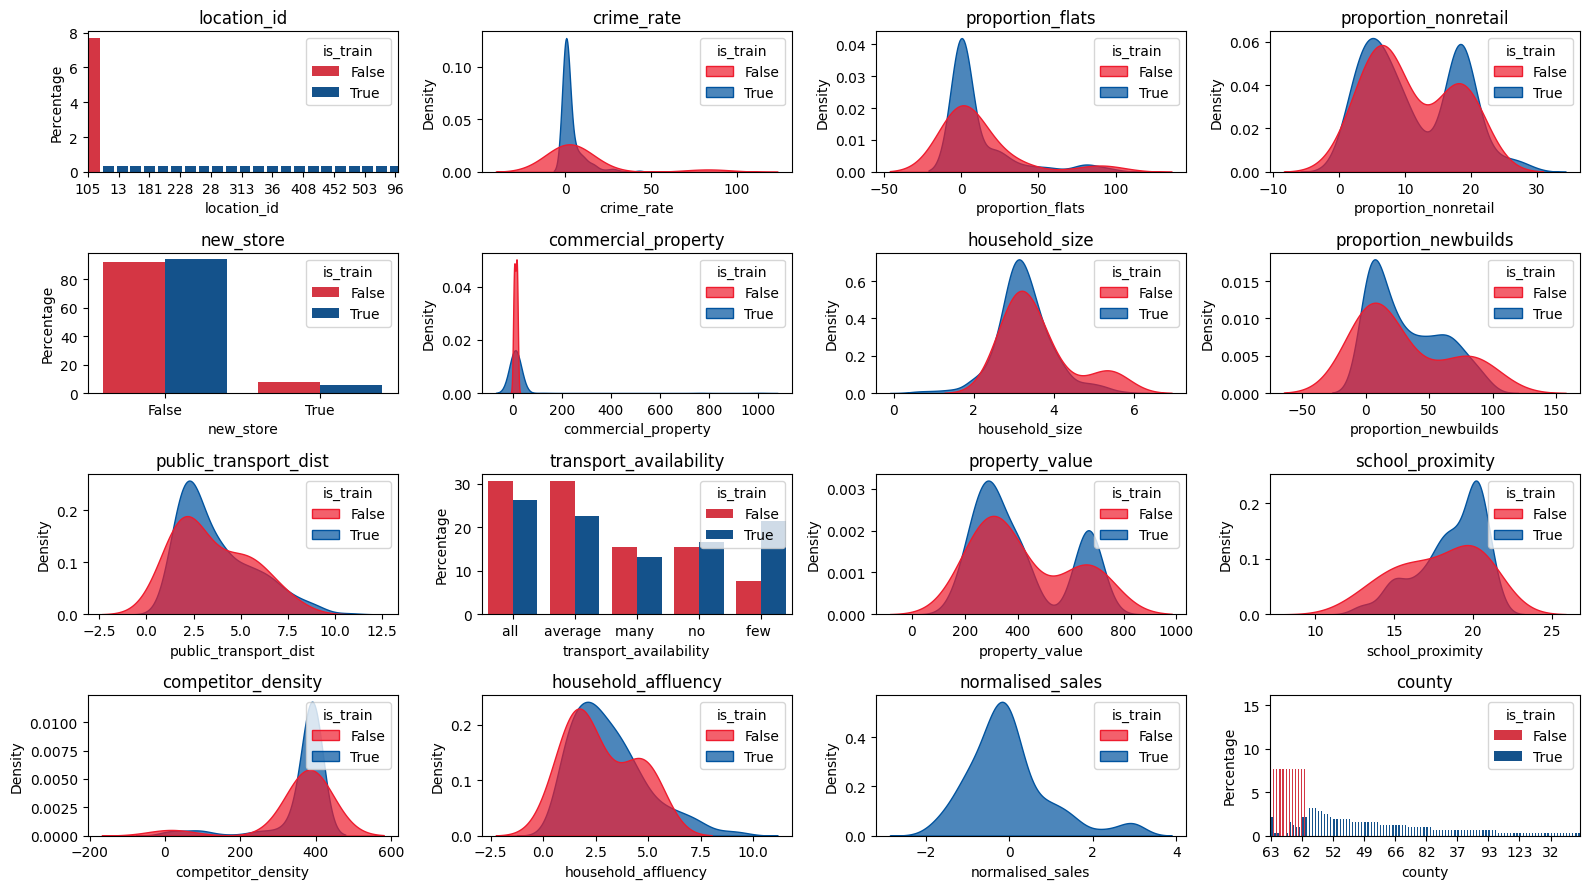

In [4]:
display(Markdown("### Figure 1:"))
df = load_preprocessed_data("tesco_dataset")
fig_1 = distribution_view(df)
# !!!!!!!!!! Location ID seems to be wrong (remove or fix) !!!!!!!!!!!!!!!!


### High frequency of zeros in some variables

| Variable | N | % |
| --- | --- | --- |
| `proportion_flats` | 248 | 74.5% |
| `proportion_newbuilds` | 26 | 7.8% |

I would like to confirm with them if these are missing values or actual zero numbers. It is not uncommon in the UK to have regions with only old buildings and no flats, so these could be real values. However, the proportion of regions with no flats seems to be excessive, so I would double-check that.

### The County Code is highly correlated to the target variable

The County code seems to be a linear function with noise from the County Code number, see [Fig. 2](#Figure-2:-Correlation-with-County-Code) and [Table 1](#Table-1:-Correlation-with-County-Code). Other key variables are also correlated to the County code. Notably, household affluence is an exponential function of the code. It looks like the code was designed from a table sorted by `normalised_sales`. Using this variable to train the model would give great results in a validation set (a sub-set of the train data used to measure the model's performance) but would not generalise to unseen counties. We shall exclude this variable from the training set. I would  also ask the Stores Team about how this happened.

I assume that the correlation between the other variables is done by design and is a feature of this (probably synthetic) dataset.
Therefore, I will not raise further questions about their correlations and behaviours.


# Table 1: Correlation with County Code and Normalised Sales

|                       |   Correlation with County Code |
|:----------------------|-------------------------------:|
| county_code           |                      1         |
| normalised_sales      |                      0.793919  |
| household_affluency   |                      0.611673  |
| household_size        |                      0.57991   |
| proportion_nonretail  |                      0.386911  |
| property_value        |                      0.350498  |
| crime_rate            |                      0.316289  |
| proportion_flats      |                      0.313049  |
| proportion_newbuilds  |                      0.312696  |
| school_proximity      |                      0.302263  |
| competitor_density    |                      0.251854  |
| public_transport_dist |                      0.208313  |
| commercial_property   |                      0.0732871 |

|                       |   Correlation with Normalised Sales |
|:----------------------|------------------------------------:|
| normalised_sales      |                           1         |
| county_code           |                           0.793919  |
| household_affluency   |                           0.743277  |
| household_size        |                           0.692506  |
| proportion_nonretail  |                           0.485237  |
| property_value        |                           0.463462  |
| school_proximity      |                           0.447789  |
| crime_rate            |                           0.445005  |
| proportion_newbuilds  |                           0.380474  |
| proportion_flats      |                           0.355756  |
| competitor_density    |                           0.338284  |
| public_transport_dist |                           0.268658  |
| commercial_property   |                           0.0650906 |

# Figure 2: Correlation with County Code and Normalised Sales

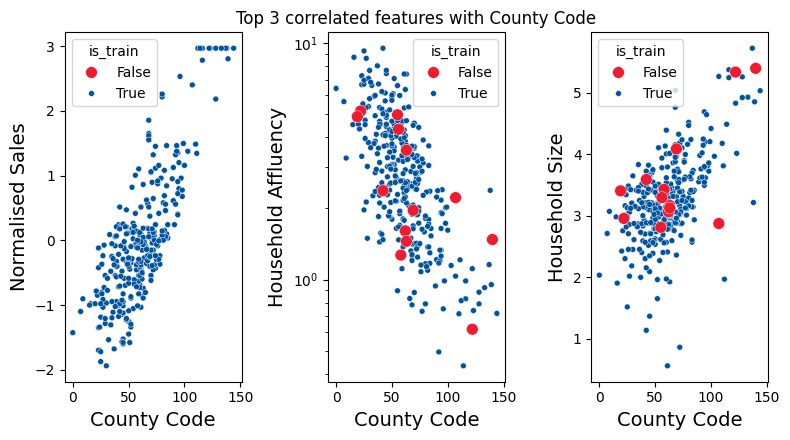

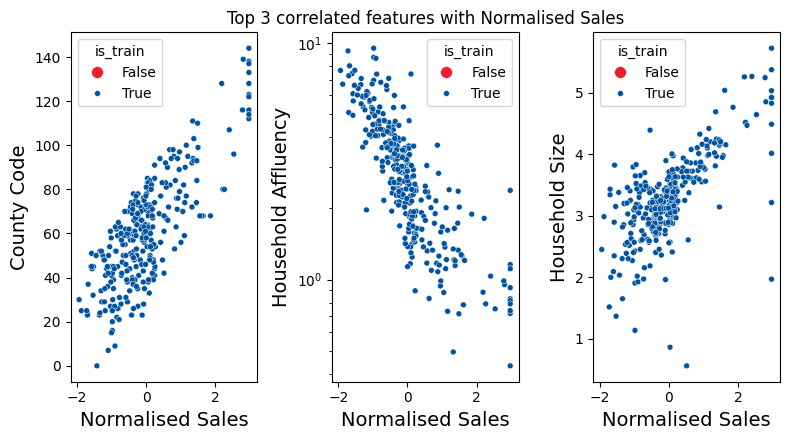

In [5]:
df["county_code"] = df["county"].astype("int")
fig_2a, count_correlated_features = top_correlated_features(df, target="county_code", n_top=3)
fig_2b, sales_correlated_features = top_correlated_features(df, target="normalised_sales", n_top=3)
display(Markdown("# Table 1: Correlation with County Code and Normalised Sales"))
display(Markdown(count_correlated_features.to_markdown()), Markdown(sales_correlated_features.to_markdown()))
display(Markdown("# Figure 2: Correlation with County Code and Normalised Sales"))

# They would also like to know which other information you think would be useful to collect for future developments.
- Transform the normalised sales into a more tangible metric
    
    It would be interesting to understand how the normalised sales values translate to real £ values. This would help communicate the final results of the model, including predictions of how wrong we can be about a location and how much money that mistake could cost. In the same way, it would help to better understand the threshold on sales that would justify opening a store there.
    
- Type of store, maintenance costs, transportation costs and more
    
    I suppose that the normalization of the sales takes into account the type of store (Extra, Metro, Express, etc.), the maintenance costs and the transportation costs of the stores. The maintenance cost, for instance, may vary substantially depending on the size of the store and features like customer cash/card habits, security, and many others. So, I would like to understand better if these things are considered in the normalisation process or if it would be important to add them as model features. Raising these questions, I would enquire about other characteristics that could be even more important. The Stores Team would likely have people with domain knowledge who could help design this model better.
    
- Competitor density per competitor
    
    I suspect that not all competitors affect sales equally, so breaking down the competitor density by the top brand would be good. I would also investigate how to build a feature like the distance to the closest competitor with a store comparable to or larger than the existing store. A Sainsbury's local next to a Tesco Extra should be less disruptive than the same store next to a Tesco Express, I suppose. However, I would consult the Stores Team on this hypothesis and other hypotheses.

-------------

## Q2
Build a model that can predict store sales based on the provided area features. Please show how you developed the model and report how well your model is performing. ***Constraint:*** Please use Random Forest as the model family to solve this problem.

In [6]:
# Remove the county column and set location_id as the Index
Xy = sales_model.clean_data(df.copy())
# Split the data for Training, validating and testing accordingly
random_state = 1919
# fix random seed for reproducibility
np.random.seed(random_state)
X_train, X_val, X_test, y_train, y_val, y_test = sales_model.split_data(Xy, random_state)
# Create a pipeline to handle preprocessing and model training
# The pipeline applies Standard Scaling of the numerical variables and One Hot Encoding of the categorical variables
numeric_features = X_train.select_dtypes(include=["number"]).columns
categorical_features = X_train.select_dtypes(include=["object", "string"]).columns
# The pipeline is flexible to the use of different models. In this case, we are sticking to the requirement of using Random Forest
model_pipeline = sales_model.create_pipeline(RandomForestRegressor(), numeric_features, categorical_features)

In [7]:
# Use RandomizedSearchCV to optimise the hyperparameters of the model
param_grid = {
    "Regressor__n_estimators": [80, 100, 120, 200],
    "Regressor__random_state": randint(0, random_state),
}
regressor = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_grid,
    n_iter=100,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    cv=5,
    random_state=random_state,
    verbose=1,
)
regressor.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Preprocessor',
                                              ColumnTransformer(transformers=[('MinMaxScaler '
                                                                               'Numerical '
                                                                               'scaler',
                                                                               MinMaxScaler(),
                                                                               Index(['crime_rate', 'proportion_flats', 'proportion_nonretail',
       'commercial_property', 'household_size', 'proportion_newbuilds',
       'public_transport_dist', 'property_value', 'school_proximity',
       'competitor_densit...
                                                                               Index(['new_store', 'transport_availability'], dtype='object'))])),
                                             ('Regressor',
                                              RandomForestRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'Regressor__n_estimators': [80, 100,
                                                                    120, 200],
                                        'Regressor__random_state': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x75d674775310>},
                   random_state=1919, scoring='neg_mean_squared_error',
                   verbose=1)

In [8]:
# Train a baseline model for comparison. I have compared it with a Dummy Regressor, as a Linear Regressor, but here I will use a non-optimised model as a comparison.
baseline_regressor = sales_model.create_pipeline(RandomForestRegressor(random_state=random_state), numeric_features, categorical_features)
baseline_regressor.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('MinMaxScaler Numerical '
                                                  'scaler',
                                                  MinMaxScaler(),
                                                  Index(['crime_rate', 'proportion_flats', 'proportion_nonretail',
       'commercial_property', 'household_size', 'proportion_newbuilds',
       'public_transport_dist', 'property_value', 'school_proximity',
       'competitor_density', 'household_affluency'],
      dtype='object')),
                                                 ('Categoric encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  Index(['new_store', 'transport_availability'], dtype='object'))])),
                ('Regressor', RandomForestRegressor(random_state=1919))])

In [10]:
y_val_pred = regressor.predict(X_val)
y_train_pred = regressor.predict(X_train)
y_test_pred, final_model = sales_model.test_set_prediction(X_train, X_val, X_test, y_train, y_val, regressor)

y_pred_baseline = baseline_regressor.predict(X_val)
y_train_pred_baseline = baseline_regressor.predict(X_train)
y_test_pred_baseline = baseline_regressor.predict(X_test)

df_complete = sales_model.add_predictions_to_df(df, X_train, X_val, X_test, y_train_pred, y_val_pred, y_test_pred)
df_complete_baseline = sales_model.add_predictions_to_df(
    df, X_train, X_val, X_test, y_train_pred_baseline, y_pred_baseline, y_test_pred_baseline
)
model_metrics = sales_model.metrics(df_complete, "normalised_sales", "predicted_normalised_sales")
model_metrics_baseline = sales_model.metrics(
    df_complete_baseline, "normalised_sales", "predicted_normalised_sales", "Vanilla Random Forest Regressor"
)
metrics_comparison = pd.concat([model_metrics, model_metrics_baseline], axis=1)
display(Markdown("# Table 2: Model Performance Metrics"))
display(metrics_comparison)

# Table 2: Model Performance Metrics

,Validation Random Forest,Train Random Forest,Validation Vanilla Random Forest Regressor,Train Vanilla Random Forest Regressor
mean_squared_error,0.262973,0.083498,0.264843,0.095422
mean_absolute_error,0.320012,0.217294,0.329476,0.225402
r2_score,0.795195,0.903440,0.793740,0.889651


# Figure 4a: Visual inspection of predictions

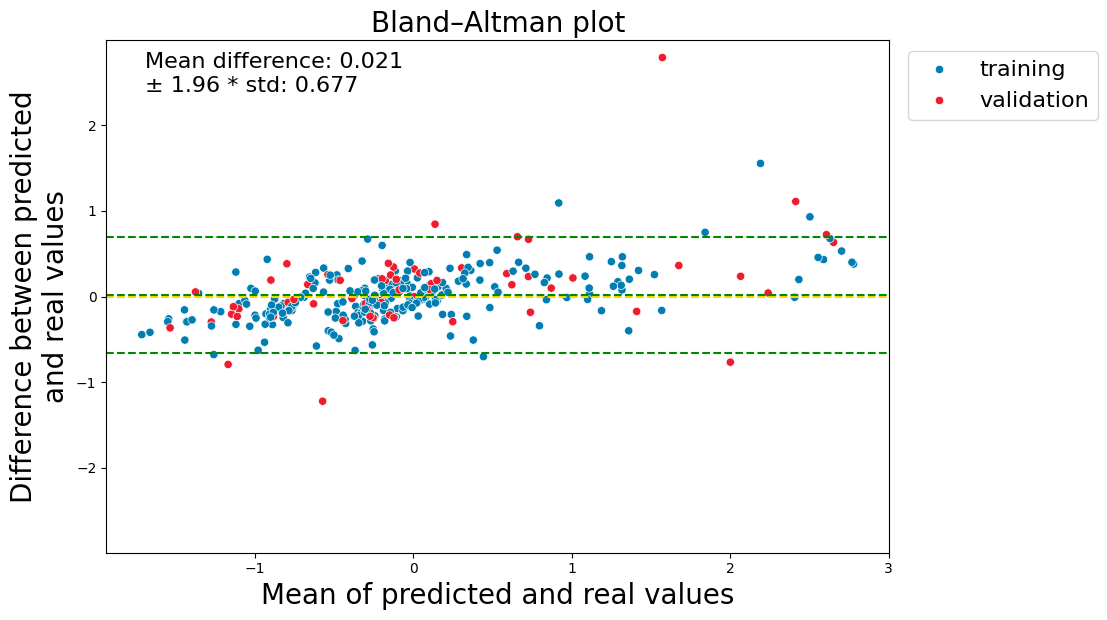

# Figure 4b:

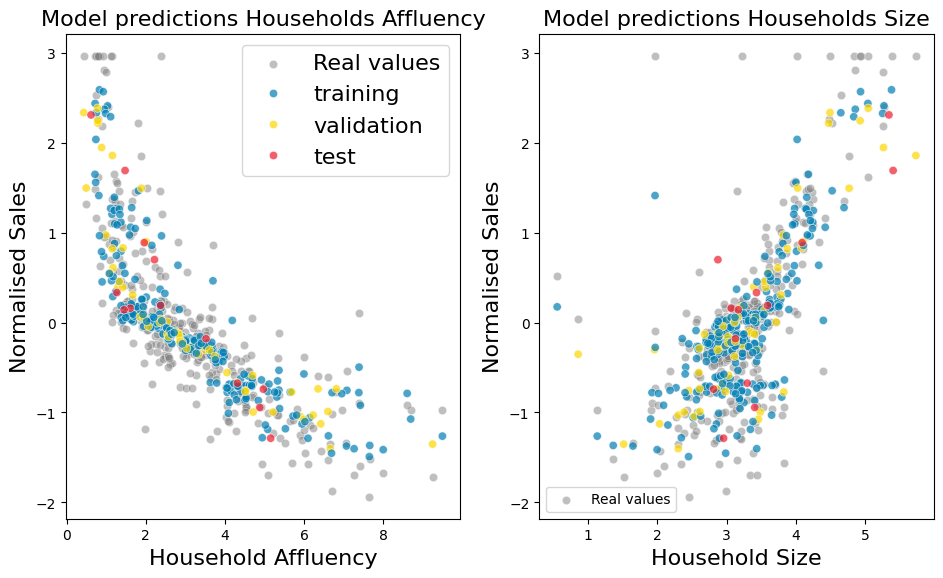

In [11]:
model_path = "models/tesco_dataset/"
os.makedirs(model_path, exist_ok=True)
# %%
display(Markdown("# Figure 4a: Visual inspection of predictions"))
fig = sales_model.bland_altman_plot(df_complete)
fig.savefig("models/tesco_dataset/tesco_sales_model_bland_altman_plot.png")
plt.show()
display(Markdown("# Figure 4b:"))
fig = sales_model.compare_original_and_predicted_data(df, df_complete)
fig.savefig("models/tesco_dataset/tesco_sales_model_real_data_comparison.png")
plt.show()


# Figure 5:

PermutationExplainer explainer: 189it [00:17,  5.65it/s]                                                                                                                    


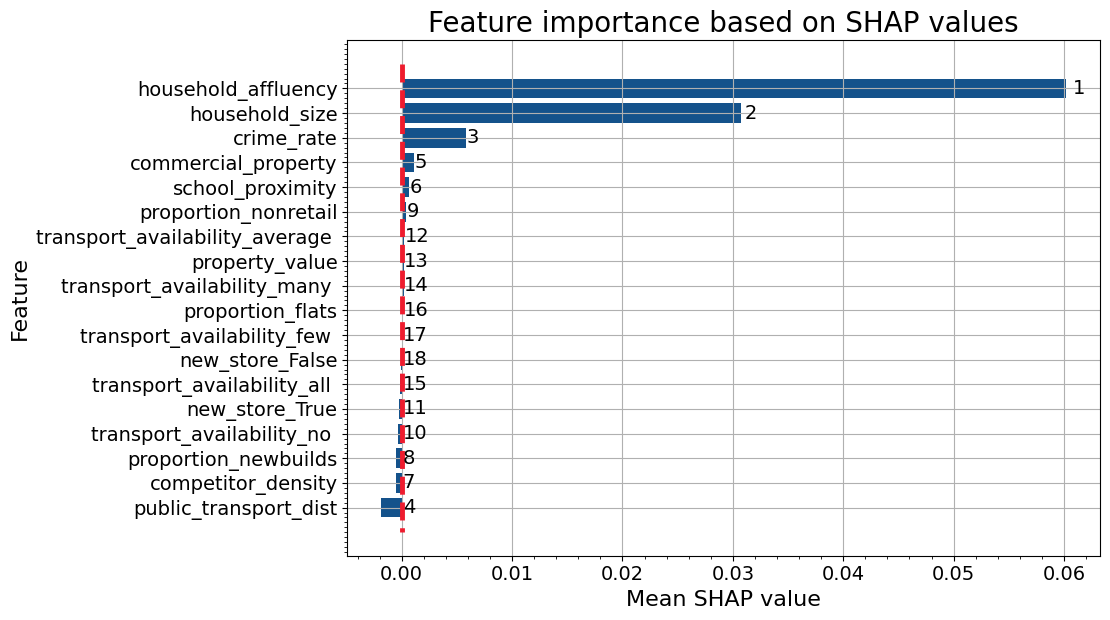

In [12]:
# Feature importance analysis
display(Markdown("# Figure 5:"))
sales_model.feature_importance_analysis(final_model, X_train)
plt.show()

In [14]:
# Save model results
model_file = "tesco_sales_model.pkl"
results_file = "tesco_sales_model_results.csv"
metrics_file = "tesco_sales_model_metrics.csv"
metrics_comparison.to_csv(f"{model_path}{metrics_file}")

test_set = df[~df["is_train"]].copy()
test_set.loc[:, "normalised_sales"] = y_test_pred
sales_quantiles = df["normalised_sales"].quantile([0.25, 0.5, 0.75])
test_set["sales_quartile"] = pd.qcut(test_set["normalised_sales"], q=100, labels=[f"top {100 - percent}%" if percent > 50 else f"bottom {percent}%" for percent in range(0, 100, 1)])
test_set.sort_values("normalised_sales", ascending=False, inplace=True)
test_set.to_csv(f"{model_path}{results_file}")
joblib.dump(final_model, f"{model_path}{model_file}")

['models/tesco_dataset/tesco_sales_model.pkl']

-------------

## Q3
The dataset contains a test set of potential store locations. Use your developed model to predict the sales value in these areas and explain what recommendations you would give to the Stores Team to use it. Use any tools that may help you to share your findings with product owners and other non-technical decision makers in the team. Complete this task by explaining how you would improve the current results.

### On [this link](https://docs.google.com/presentation/d/10cf3d1t99Uznn3wze9HzeybepQNHmqOcg1uCfwIz3-U/edit#slide=id.g2b854166a7b_0_14) you can find presentation with  of the information here to better communicate with product owners and other non-technical 

## Summary

### Expected sales:
    
We have created a model that can predict the normalised sales values based on location characteristics. This is useful for the Stores Team to make decisions on whether to open new stores in these locations or set performance benchmarks for existing locations. However, it's essential to note that we should avoid using this model for locations that were included in the training set.
    
### How do you use this model to open new stores?
    
The Stores Team can use the information presented in this report to make informed decisions when opening new stores while taking into account other business constraints. For instance, if they only have a budget to open three new stores, it would be wise to focus on the locations that are likely to perform better. In [Table 3](#Table-3:-Predicted-sales), we can observe that stores 148, 400, and 477 rank among the top 20% of the highest normalised sales. Store 148, in particular, is in the top 1%. However, it's important to note that the data on stores top-performing stores is limited, so it's possible that location 148 will perform at the same level or worse than 400. Therefore, I suggest these two locations are the best options, but if the team can only pick one, they should rely on additional information to decide which of these 2 locations to choose. 
    
Moreover, Stores located in areas 199, 227, and 341, along with the previously mentioned, have the potential to outperform the median Tesco store. 
    
Finally, If we assume that a positive sign on the normalised sales indicates profitability and a negative sign indicates losses, then we would not recommend opening stores in areas 114, 136, 203, 338, and 363 even if there was a budget to open as many stores as possible. Meanwhile, stores 12 and 105 are expected to be profitable but will likely perform worse than the median Tesco store.

In [15]:
display(Markdown("# Table 3: Predicted sales"))
test_set.set_index("location_id")[["normalised_sales", "sales_quartile"]].sort_values("normalised_sales", ascending=False)

# Table 3: Predicted sales

,normalised_sales,sales_quartile
location_id,,
148,2.309850,top 1%
400,1.691257,top 9%
477,0.888654,top 17%
199,0.699204,top 26%
341,0.333380,top 34%
105,0.189712,top 42%
227,0.159576,bottom 49%
12,0.141521,bottom 41%
363,-0.179966,bottom 33%


-------------

## Masked Dataset

You are given the following small dataset, which has been completely masked for privacy reasons. Please train the best model you can come up with to predict the target variable `y` based on the features `x1` and `x2`. Explain every step you take. 

Assuming that this model will be used for making decisions involving important sums of money, provide any comments that you think you should be giving to the business as a technical expert.

Dataset files
* `masked_dataset/train.csv`